# parameter tuned
reference : https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features/versions#base=4143658&new=4153250

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
!ls

aguiar's_kernel.ipynb
data_visualize.ipynb
feature_matrix.csv
feature_selection-feature_by_kageyama-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection-feature_by_olivier-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection_feature_matrix_by_kageyama.ipynb
feature_selection_feature_matrix_by_olivier.ipynb
feature_selection_feature_matrix_noIDs_by_kageyama.ipynb
featuretools-for-Kageyama.ipynb
featuretools-for-aguiar.ipynb
featuretools-for-olivier.ipynb
featuretools.ipynb
kageyama-25CV_noIDs_delunimportant_90.ipynb
kageyama-25CV_noIDs_delunimportant_92.ipynb
kageyama-25CV_noIDs_delunimportant_94.ipynb
kageyama-25CV_noIDs_delunimportant_96.ipynb
kageyama-25CV_noIDs_delunimportant_98.ipynb
kageyama_90_sub.csv
kageyama_94_sub.csv
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs.csv
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs_delmissing_delunimportant_794.csv
kageyama_feature_matrix_90.0.csv
kageyama_feature_matrix_92.0.csv
kageyama_feature_matrix_94.0.csv
kageyama_feature_mat

In [3]:
st = time.time()
df = pd.read_csv('./kageyama_feature_matrix_92.0.csv')
time.time() - st

59.35833024978638

In [4]:
df = df.drop('SK_ID_CURR', axis=1)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


43

In [6]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.759212	valid_1's auc: 0.752015
[200]	training's auc: 0.780824	valid_1's auc: 0.763745
[300]	training's auc: 0.79813	valid_1's auc: 0.77325
[400]	training's auc: 0.809692	valid_1's auc: 0.77849
[500]	training's auc: 0.818856	valid_1's auc: 0.780709
[600]	training's auc: 0.826807	valid_1's auc: 0.78244
[700]	training's auc: 0.833942	valid_1's auc: 0.783733
[800]	training's auc: 0.84042	valid_1's auc: 0.784509
[900]	training's auc: 0.846334	valid_1's auc: 0.785091
[1000]	training's auc: 0.852101	valid_1's auc: 0.786036
[1100]	training's auc: 0.857459	valid_1's auc: 0.786571
[1200]	training's auc: 0.862446	valid_1's auc: 0.786672
[1300]	training's auc: 0.867142	valid_1's auc: 0.786992
[1400]	training's auc: 0.871807	valid_1's auc: 0.78721
[1500]	training's auc: 0.87624	valid_1's auc: 0.787022
Early stopping, best iteration is:
[1429]	training's auc: 0.873123	valid_1's auc: 0.787362
Fold  1 AUC : 0.787362

Fold  8 AUC : 0.787841
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.759263	valid_1's auc: 0.746032
[200]	training's auc: 0.780769	valid_1's auc: 0.759169
[300]	training's auc: 0.79807	valid_1's auc: 0.767814
[400]	training's auc: 0.80958	valid_1's auc: 0.773361
[500]	training's auc: 0.818825	valid_1's auc: 0.7763
[600]	training's auc: 0.826809	valid_1's auc: 0.777997
[700]	training's auc: 0.833832	valid_1's auc: 0.77951
[800]	training's auc: 0.840502	valid_1's auc: 0.780278
[900]	training's auc: 0.846348	valid_1's auc: 0.781023
[1000]	training's auc: 0.852005	valid_1's auc: 0.782273
[1100]	training's auc: 0.857372	valid_1's auc: 0.782869
[1200]	training's auc: 0.862007	valid_1's auc: 0.783429
[1300]	training's auc: 0.866667	valid_1's auc: 0.783609
[1400]	training's auc: 0.87136	valid_1's auc: 0.784475
[1500]	training's auc: 0.876024	valid_1's auc: 0.784984
[1600]	training's auc: 0.880352	valid_1's auc: 0.785449
[1700]	training's auc: 0.884263	v

[600]	training's auc: 0.826701	valid_1's auc: 0.790433
[700]	training's auc: 0.833731	valid_1's auc: 0.791882
[800]	training's auc: 0.840303	valid_1's auc: 0.793293
[900]	training's auc: 0.846309	valid_1's auc: 0.794183
[1000]	training's auc: 0.851879	valid_1's auc: 0.794675
[1100]	training's auc: 0.857119	valid_1's auc: 0.795363
[1200]	training's auc: 0.86209	valid_1's auc: 0.795825
[1300]	training's auc: 0.866936	valid_1's auc: 0.795988
[1400]	training's auc: 0.871567	valid_1's auc: 0.796312
Early stopping, best iteration is:
[1359]	training's auc: 0.869677	valid_1's auc: 0.796458
Fold 16 AUC : 0.796458
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758641	valid_1's auc: 0.758971
[200]	training's auc: 0.780476	valid_1's auc: 0.772837
[300]	training's auc: 0.797572	valid_1's auc: 0.783882
[400]	training's auc: 0.809077	valid_1's auc: 0.789671
[500]	training's auc: 0.818428	valid_1's auc: 0.793013
[600]	training's auc: 0.826652	valid_1's auc: 0.7

[1300]	training's auc: 0.866829	valid_1's auc: 0.797705
[1400]	training's auc: 0.871293	valid_1's auc: 0.798038
[1500]	training's auc: 0.875791	valid_1's auc: 0.798338
[1600]	training's auc: 0.880077	valid_1's auc: 0.798371
[1700]	training's auc: 0.884366	valid_1's auc: 0.798382
Early stopping, best iteration is:
[1660]	training's auc: 0.882686	valid_1's auc: 0.798517
Fold 25 AUC : 0.798517
Full AUC score 0.793459


In [7]:
sub.to_csv('./kageyama_92_sub.csv', index=None)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


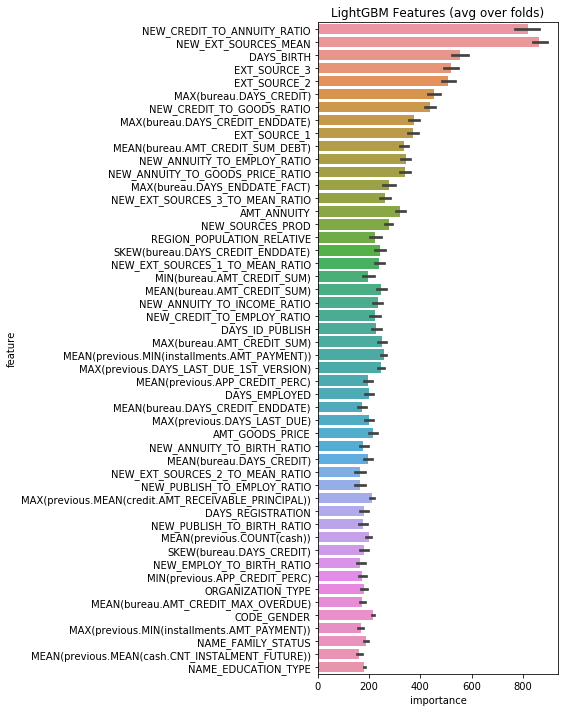

In [9]:
display_importances(feature_importance_df)

In [10]:
time.time() - st

9766.64671754837